In [18]:
import re
import xml.etree.ElementTree as ET
from pathlib import Path
from typing import Dict, Optional, Iterable, Tuple

import numpy as np
import pandas as pd
from Bio import Phylo
from Bio.Phylo.BaseTree import Tree as BioTree, Clade
from scipy.stats import linregress
import matplotlib.pyplot as plt


class RootToTipAnalyzer:
    """
    Reusable utility for BEAST/GenBank datasets:
      • parse BEAST XML tip dates (using taxon id or prefix before '|')
      • load/reroot a Newick tree
      • compute root-to-tip distances
      • assemble analysis dataframe
      • fit and plot root-to-tip regression

    Parameters
    ----------
    xml_path : str|Path
        BEAST XML containing <taxon id="..."><date value="..."/></taxon>.
    newick_path : str|Path
        Newick tree path readable by Bio.Phylo.
    outgroup_pattern : str
        Substring or regex to identify the outgroup tip used for rerooting.
    highlight_regex : str
        Regex (case-insensitive) marking tips of interest (e.g., r"(?:SNVT|MIPE|PESO)").
    use_taxon_prefix : bool
        If True, match tip dates using the prefix before the first '|' in the taxon id.
        If False, use the full taxon id string.
    date_field : str
        XML child tag suffix to detect a date-like element (default: tags ending with 'date').
    """

    def __init__(self,
                 xml_path: Path | str,
                 newick_path: Path | str,
                 outgroup_pattern: str,
                 highlight_regex: str = r"(?:SNVT|MIPE|PESO)",
                 use_taxon_prefix: bool = True,
                 exclude_regex: str | None = None,
                 exclude_list: Iterable[str] | None = None,
                 exclude_file: str | Path | None = None,
                 date_field: str = "date") -> None:
        self.xml_path = Path(xml_path)
        self.newick_path = Path(newick_path)
        self.outgroup_pattern = outgroup_pattern
        self.highlight_re = re.compile(highlight_regex, flags=re.I)
        self.use_taxon_prefix = use_taxon_prefix
        self.exclude_regex = re.compile(exclude_regex, re.I) if exclude_regex else None
        self.exclude_set: set[str] = set()
        if exclude_list:
            self.exclude_set |= {self._prefix_or_full(str(x)).upper() for x in exclude_list}
        if exclude_file:
            self.exclude_set |= self._load_exclusion_file(exclude_file)
        self.date_field = date_field.lower()

        self.tipdates: Dict[str, float] = {}
        self.tree: Optional[BioTree] = None
        self.df: Optional[pd.DataFrame] = None
        self._fit: Optional[Tuple[float, float, float, float, float]] = None  # slope, intercept, r, p, stderr

    # --------------------------- Parsing ---------------------------

    @staticmethod
    def _prefix_or_full(s: str) -> str:
        return s.split("|", 1)[0].strip() if "|" in s else s.strip()

    def parse_beast_tipdates(self) -> Dict[str, float]:
        """Extract {taxon_id or prefix -> numeric date} from BEAST XML."""
        root = ET.parse(self.xml_path).getroot()
        tipdates: Dict[str, float] = {}
        for taxon in root.findall(".//taxon"):
            tid = taxon.attrib.get("id")
            if not tid:
                continue
            key = self._prefix_or_full(tid) if self.use_taxon_prefix else tid.strip()
            for child in taxon:
                if child.tag.lower().endswith(self.date_field) and ('value' in child.attrib):
                    try:
                        tipdates[key] = float(child.attrib['value'])
                    except Exception:
                        pass
        self.tipdates = tipdates
        return tipdates
    
    def _load_exclusion_file(self, path: str | Path) -> set[str]:
        p = Path(path)
        vals: list[str] = []
        if p.suffix.lower() in {'.txt', '.list'}:
            vals = [ln.strip() for ln in p.read_text().splitlines() if ln.strip() and not ln.startswith('#')]
        elif p.suffix.lower() == '.tsv':
            import pandas as pd
            df = pd.read_csv(p, sep='\t')
            # prefer a column named 'tip' or 'id'; else use the first column
            col = next((c for c in df.columns if c.lower() in {'tip','id','name'}), df.columns[0])
            vals = [str(x) for x in df[col].dropna().tolist()]
        else:
            # fallback: treat as newline-delimited text
            vals = [ln.strip() for ln in p.read_text().splitlines() if ln.strip() and not ln.startswith('#')]
        return {self._prefix_or_full(v).upper() for v in vals}

    def _excluded(self, raw_name: str) -> bool:
        nm = (raw_name or '')
        nm_clean = self._clean_tip_label(nm)
        key = self._prefix_or_full(nm_clean).upper()
        if key in self.exclude_set:
            return True
        if self.exclude_regex and self.exclude_regex.search(nm_clean):
            return True
        return False

    # --------------------------- Tree ops --------------------------

    @staticmethod
    def _clean_tip_label(s: str) -> str:
        return s.strip().strip("'").strip('"')

    @staticmethod
    def _root_to_tip(tree: BioTree) -> Dict[str, float]:
        d: Dict[str, float] = {}
        for tip in tree.get_terminals():
            path = tree.get_path(tip)
            d[tip.name] = sum((cl.branch_length or 0.0) for cl in path)
        return d

    def _find_outgroup(self, tree: BioTree) -> Clade:
        # accept substring or regex
        pats = [self.outgroup_pattern] if isinstance(self.outgroup_pattern, str) else list(self.outgroup_pattern)
        cand: Iterable[Clade] = tree.get_terminals()
        for tip in cand:
            nm = tip.name or ""
            if any((re.search(p, nm) if p.startswith('(') or any(ch in p for ch in '[]|?*+^$') else (p in nm))
                   for p in pats):
                return tip
        raise ValueError(f"Outgroup pattern not found: {self.outgroup_pattern}")

    @staticmethod
    def _midpoint_adjust_after_reroot(tree: BioTree, outgroup_tip: Clade) -> None:
        # After root_with_outgroup, Bio.Phylo already splits the branch.
        # If desired, one can tweak lengths; here we leave as produced by Bio.Phylo.
        return

    def load_and_reroot(self) -> BioTree:
        tree = Phylo.read(self.newick_path, "newick")
        og = self._find_outgroup(tree)
        tree.root_with_outgroup(og)
        self._midpoint_adjust_after_reroot(tree, og)
        self.tree = tree
        return tree

    # --------------------------- Analysis --------------------------

    def build_dataframe(self) -> pd.DataFrame:
        if not self.tipdates:
            self.parse_beast_tipdates()
        if self.tree is None:
            self.load_and_reroot()

        rtt = self._root_to_tip(self.tree)
        rows = []
        for tip in self.tree.get_terminals():
            if self._excluded(tip.name):
                continue
            nm_clean = self._clean_tip_label(tip.name)
            key = self._prefix_or_full(nm_clean) if self.use_taxon_prefix else nm_clean
            if key in self.tipdates:
                rows.append({
                    "tip": nm_clean,
                    "root_to_tip": rtt.get(tip.name, np.nan),
                    "date": self.tipdates[key],
                    "highlight": bool(self.highlight_re.search(nm_clean))
                })
        self.df = pd.DataFrame(rows).dropna(subset=["date", "root_to_tip"])
        return self.df
    

    def fit_regression(self) -> Tuple[float, float, float, float, float]:
        if self.df is None or self.df.empty:
            self.build_dataframe()
        slope, intercept, r, p, stderr = linregress(self.df["date"].values,
                                                    self.df["root_to_tip"].values)
        self._fit = (slope, intercept, r, p, stderr)
        return self._fit

    # --------------------------- Plotting --------------------------

    def plot(self,
             figsize: Tuple[float, float] = (6, 4),
             colors: Tuple[str, str] = ("slateblue", "orange"),
             label_names: Tuple[str, str] = ("PNW (New)", "GenBank"),
             show: bool = True,
             save: Optional[str | Path] = None,
             dpi: int = 300) -> dict:
        """
        Scatter + regression line. Returns a dict with fit metrics.
        """
        if self.df is None:
            self.build_dataframe()
        if self._fit is None:
            self.fit_regression()
        slope, intercept, r, p, stderr = self._fit

        df = self.df.copy()
        df["color"] = np.where(df["highlight"], colors[0], colors[1])

        fig, ax = plt.subplots(figsize=figsize)
        ax.scatter(df["date"], df["root_to_tip"], c=df["color"], s=20)

        x = df["date"].values
        ax.plot(x, intercept + slope * x, color="red", lw=1, label="Fit")

        # proxy legend handles
        ax.scatter([], [], c=colors[0], label=label_names[0])
        ax.scatter([], [], c=colors[1], label=label_names[1])

        ax.set_xlabel("Sampling date (decimal years)")
        ax.set_ylabel("Root-to-tip distance (substitutions/site)")
        ax.set_title("Root-to-tip regression")
        ax.legend(frameon=False)
        plt.tight_layout()

        if save:
            plt.savefig(save, dpi=dpi, bbox_inches="tight")
        if show:
            plt.show()
        else:
            plt.close(fig)

        # intercept in x (time) where line crosses 0 branch length
        x_intercept = -intercept / slope if slope != 0 else np.nan
        return {
            "slope": slope,
            "intercept": intercept,
            "r2": r ** 2,
            "pvalue": p,
            "stderr": stderr,
            "x_intercept": x_intercept,
            "n": len(df)
        }




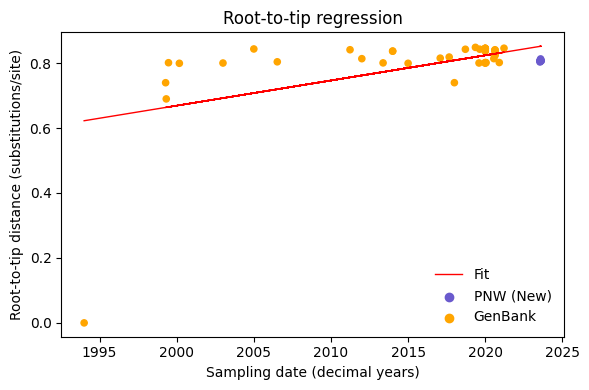

{'slope': 0.007749654744657788, 'intercept': -14.830332885822495, 'r2': 0.2574039277079226, 'pvalue': 0.00010562658214081588, 'stderr': 0.0018431726003192716, 'x_intercept': 1913.676592630886, 'n': 53}


In [19]:
analyzer = RootToTipAnalyzer(
    xml_path="../Avail_seqs/L/SNV_L_NCBI_MEZAP.xml",
    newick_path="../Avail_seqs/aligned/snvLRna.contree",
    outgroup_pattern="MG717393.1",         # substring or regex for the outgroup tip 'MG717393.1' for L; 'MG717392.1' for M; 'MG717391.1' for S
    highlight_regex=r"(?:SNVT|MIPE|PESO|MIMO|PEMA)", # mark Whitman/related tips
    exclude_regex=r"\bWHIT\b",
    use_taxon_prefix=True
)
df = analyzer.build_dataframe()
metrics = analyzer.plot(figsize=(6,4), save="../Figures/rtt_L.jpeg", dpi=600)
print(metrics)

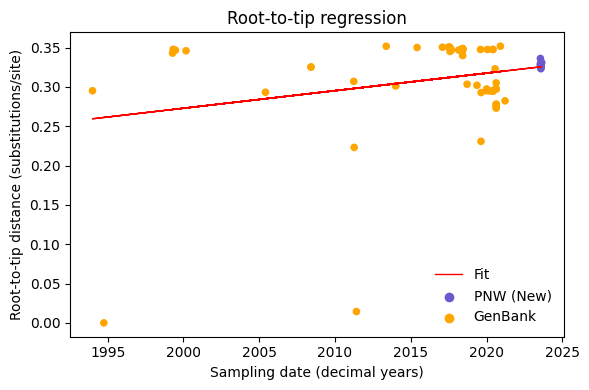

{'slope': 0.002232557811053944, 'intercept': -4.192245338689539, 'r2': 0.06786305373202997, 'pvalue': 0.028226035756673217, 'stderr': 0.000996096307205431, 'x_intercept': 1877.776834235915, 'n': 71}


In [22]:
analyzer = RootToTipAnalyzer(
    xml_path="../Avail_seqs/ncbi_whitman_aligned.xml",
    newick_path="../Avail_seqs/ncbi_whitman_aligned.fasta.treefile",
    outgroup_pattern="MG717392",         # substring or regex for the outgroup tip 'MG717392.1' for M; 'MG717391.1' for S
    highlight_regex=r"(?:SNVT|MIPE|PESO|MIMO|PEMA)", # mark Whitman/related tips
    exclude_regex=r"\bWHIT\b",
    use_taxon_prefix=True
)
df = analyzer.build_dataframe()
metrics = analyzer.plot(figsize=(6,4), save="../Figures/rtt_M.jpeg", dpi=600)
print(metrics)

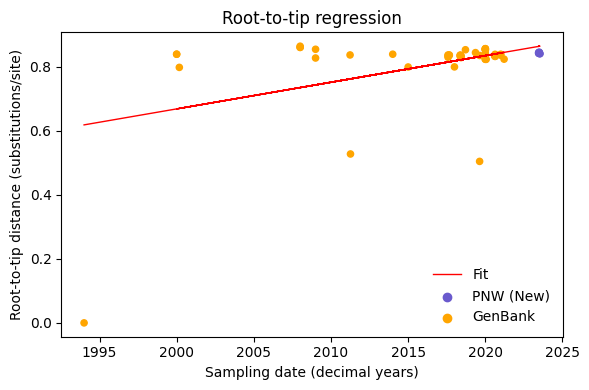

{'slope': 0.008318144279970104, 'intercept': -15.968238915619251, 'r2': 0.19783808585684592, 'pvalue': 0.00041628506923788747, 'stderr': 0.0022185288954266365, 'x_intercept': 1919.6876584685356, 'n': 59}


In [20]:
analyzer = RootToTipAnalyzer(
    xml_path="../Avail_seqs/SNV_S_NCBI_MEZAP.xml",
    newick_path="../Avail_seqs/aligned/snvSRna.contree",
    outgroup_pattern="MG717391.1",         # substring or regex for the outgroup tip 'MG717392.1' for M; 'MG717391.1' for S
    highlight_regex=r"(?:SNVT|MIPE|PESO|MIMO|PEMA)", # mark Whitman/related tips
    exclude_regex=r"\bWHIT\b",
    use_taxon_prefix=True
)
df = analyzer.build_dataframe()
metrics = analyzer.plot(figsize=(6,4), save="../Figures/rtt_S.jpeg", dpi=600)
print(metrics)